In [1]:

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob

from datetime import datetime
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Input, concatenate
from tensorflow.keras.layers import Layer, BatchNormalization, MaxPooling2D, Concatenate, Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.regularizers import l2

from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
import math
import json

from tensorflow.python.client import device_lib
import matplotlib.gridspec as gridspec

2023-09-29 20:15:29.076571: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-29 20:15:29.101279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-09-29 20:15:30.447003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 20:15:30.450533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 20:15:30.450685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
num_classes = 5

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Paths
data_dir = "AugmentAllCheetahs"
class_folders = os.listdir(data_dir)

# Initialize lists to store images and labels
images = []
labels = []

# Load and preprocess images
for label, folder_name in enumerate(class_folders):
    folder_path = os.path.join(data_dir, folder_name)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        if os.path.isdir(image_path):  # Skip directories
            continue
            
        image = load_img(image_path)  # Load image without initial resizing
        image_array = img_to_array(image)
        
        # Resize and pad using tf.image.resize_with_pad
        image_resized_padded = tf.image.resize_with_pad(image_array, 100, 100)
        images.append(image_resized_padded.numpy())
        
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the data
x_train = x_train / 255.
x_test = x_test / 255.


x_train_w = 100
x_train_h = 100
x_train_d = 3

2023-09-29 20:15:30.467873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 20:15:30.468051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 20:15:30.468168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 20:15:30.985981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 20:15:30.986800: I tensorflow/compile

In [5]:
import numpy as np
import random

def create_batch(batch_size=16, split="train"):
    # Adjust for color images: width x height x depth
    x_anchors = np.zeros((batch_size, x_train_w, x_train_h, x_train_d))
    x_positives = np.zeros((batch_size, x_train_w, x_train_h, x_train_d))
    x_negatives = np.zeros((batch_size, x_train_w, x_train_h, x_train_d))
    
    if split == "train":
        data = x_train
        data_y = y_train
    else:
        data = x_test
        data_y = y_test
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example, and a negative example
        random_index = random.randint(0, data.shape[0] - 1)
        x_anchor = data[random_index]
        y = data_y[random_index]
        
        indices_for_pos = np.squeeze(np.where(data_y == y))
        indices_for_neg = np.squeeze(np.where(data_y != y))
        
        # Safer random selection
        x_positive = data[np.random.choice(indices_for_pos)]
        x_negative = data[np.random.choice(indices_for_neg)]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]


In [6]:
def create_hard_batch(batch_size, num_hard, split="train"):
    
    # Adjust for color images: width x height x depth
    x_anchors = np.zeros((batch_size, x_train_w, x_train_h, x_train_d))
    x_positives = np.zeros((batch_size, x_train_w, x_train_h, x_train_d))
    x_negatives = np.zeros((batch_size, x_train_w, x_train_h, x_train_d))
    
    if split == "train":
        data = x_train
        data_y = y_train
    else:
        data = x_test
        data_y = y_test
    
    # Generate num_hard number of hard examples:
    hard_batches = [] 
    batch_losses = []
    
    rand_batches = []
    
    # Get some random batches
    for i in range(0, batch_size):
        hard_batches.append(create_batch(1, split))  # Adjusted create_batch function for color images
        
        A_emb = embedding_model.predict(hard_batches[i][0])
        P_emb = embedding_model.predict(hard_batches[i][1])
        N_emb = embedding_model.predict(hard_batches[i][2])
        
        # Compute d(A, P) - d(A, N) for each selected batch
        batch_losses.append(np.sum(np.square(A_emb-P_emb),axis=1) - np.sum(np.square(A_emb-N_emb),axis=1))
    
    # Sort batch_loss by distance, highest first, and keep num_hard of them
    hard_batch_selections = [x for _, x in sorted(zip(batch_losses,hard_batches), key=lambda x: x[0])]
    hard_batches = hard_batch_selections[:num_hard]
    
    # Get batch_size - num_hard number of random examples
    num_rand = batch_size - num_hard
    for i in range(0, num_rand):
        rand_batch = create_batch(1, split)  # Adjusted create_batch function for color images
        rand_batches.append(rand_batch)
    
    selections = hard_batches + rand_batches
    
    for i in range(0, len(selections)):
        x_anchors[i] = selections[i][0]
        x_positives[i] = selections[i][1]
        x_negatives[i] = selections[i][2]
        
    return [x_anchors, x_positives, x_negatives]


In [7]:
def create_embedding_model(emb_size):
    embedding_model = tf.keras.models.Sequential([
        # Start with convolutional layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(x_train_w, x_train_h, x_train_d)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        
        # Continue with dense layers
        tf.keras.layers.Dense(4096,
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(1e-3),
              kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(emb_size,
              activation=None,
              kernel_regularizer=tf.keras.regularizers.l2(1e-3),
              kernel_initializer='he_uniform')
    ])

    embedding_model.summary()
    
    return embedding_model


In [8]:
def create_SNN(embedding_model):

    # Adjust input shape to spatial dimensions of color image
    input_anchor = tf.keras.layers.Input(shape=(x_train_w, x_train_h, x_train_d))
    input_positive = tf.keras.layers.Input(shape=(x_train_w, x_train_h, x_train_d))
    input_negative = tf.keras.layers.Input(shape=(x_train_w, x_train_h, x_train_d))

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, 
                                          embedding_negative], axis=1)

    siamese_net = tf.keras.models.Model([input_anchor, input_positive, input_negative], 
                                        output)
    siamese_net.summary()
    
    return siamese_net


In [9]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size],y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [10]:
def data_generator(batch_size=16, num_hard=50, split="train"):
    while True:
        x = create_hard_batch(batch_size, num_hard, split)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [11]:
# Hyperparams
batch_size = 16
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)
val_steps = int(x_test.shape[0]/batch_size)
alpha = 0.2
num_hard = int(batch_size * 0.5) # Number of semi-hard triplet examples in the batch
lr = 0.00006
optimiser = 'Adam'
emb_size = 10


print("Generating embedding model... \n")
embedding_model = create_embedding_model(emb_size)
    
print("\nGenerating SNN... \n")
    # Create the SNN
siamese_net = create_SNN(embedding_model)
    # Compile the SNN
optimiser_obj = Adam(lr = lr)
siamese_net.compile(loss=triplet_loss, optimizer= optimiser_obj)
    
    # Store visualisations of the embeddings using PCA for display
    # Create representations of the embedding space via PCA
embeddings_before_train = embedding_model.predict(x_test[:500, :])

pca = PCA(n_components=2)
decomposed_embeddings_before = pca.fit_transform(embeddings_before_train)

Generating embedding model... 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dense (Dense)          

2023-09-29 20:16:07.415489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


16/16 [==============================] - 1s 3ms/step


2023-09-29 20:16:07.927550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
def dist(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

In [13]:
def compute_dist(a,b):
    return np.linalg.norm(a-b)

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,3) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all imgs with current embedding network
    embeddings = embedding_model.predict(X)
    
    k = 0
    
    # For each img in the evaluation set
    for i in range(m):
            # Against all other images
            for j in range(i+1,m):
                # compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tSAME".format(i,j,probs[k],k, Y[i], Y[j]))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : {2}\tDIFF".format(i,j,probs[k],k, Y[i], Y[j]))
                k += 1
    return probs, y


def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_interdist(network, epochs):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(num_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} epochs'.format(epochs))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(num_classes))

    plt.show()
    
    
def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (num_classes,num_classes) 
    '''
    res = np.zeros((num_classes,num_classes))
    
    ref_images = np.zeros((num_classes, 100, 100, 3))
    
    #generates embeddings for reference images
    for i in range(num_classes):
        ref_images[i,:] = x_test[i]
    
    ref_embeddings = network.predict(ref_images)
    
    for i in range(num_classes):
        for j in range(num_classes):
            res[i,j] = dist(ref_embeddings[i],ref_embeddings[j])
    return res

def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : result of the similarity scores with the basic images => (N)
    
    '''
    nbimages = images.shape[0]
    
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((num_classes, 100, 100, 3))
    for i in range(num_classes):
        images_at_this_index_are_of_class_i = np.squeeze(np.where(y_test == i))
        ref_images[i,:] = x_test[images_at_this_index_are_of_class_i[refidx]]
        
        
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        # Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,num_classes+1,1)
        plt.axis("off")
        plotidx = 2
            
        # Draw this image    
        plt.imshow(images[i])
        subplot.title.set_text("Test image")
            
        for ref in range(num_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,num_classes+1,plotidx)
            plt.axis("off")
            plt.imshow(ref_images[ref, :])
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

def evaluate(embedding_model, epochs = 0):
    probs,yprob = compute_probs(embedding_model, x_test[:500, :], y_test[:500])
    fpr, tpr, thresholds, auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr, thresholds, auc)
    draw_interdist(embedding_model, epochs)

    for i in range(3):
        DrawTestImage(embedding_model, np.expand_dims(x_train[i],axis=0))
        


16/16 [==============================] - 0s 2ms/step


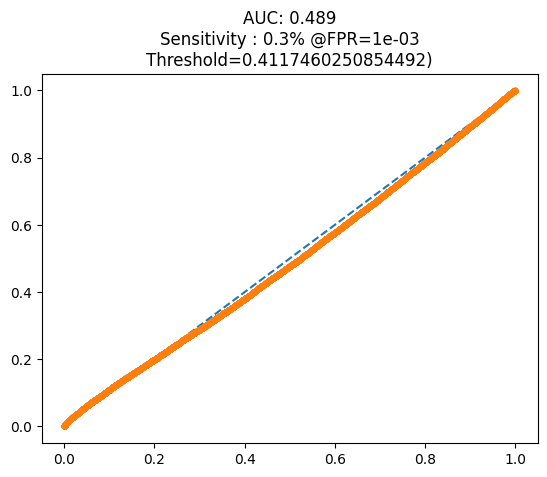

1/1 [==============================] - 0s 24ms/step


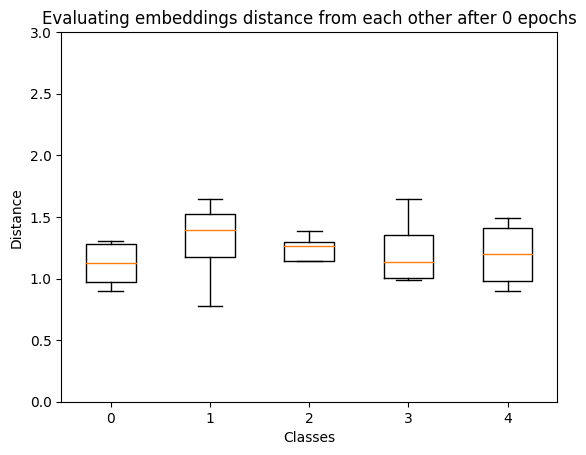

1/1 [==============================] - 0s 11ms/step


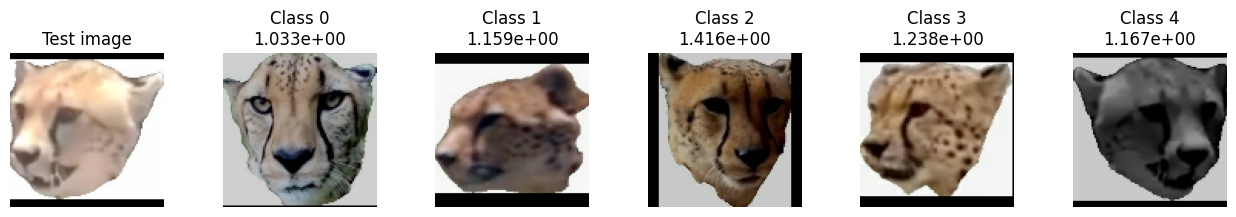

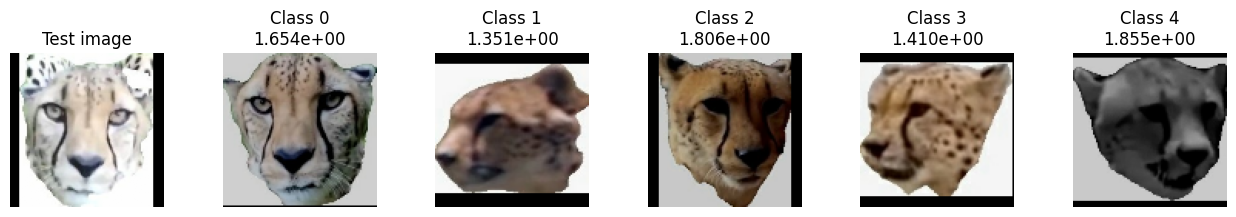

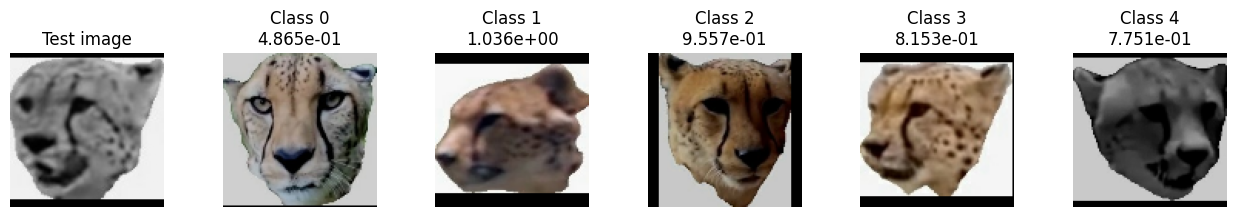

In [14]:
 evaluate(embedding_model)

Example triplet batch:


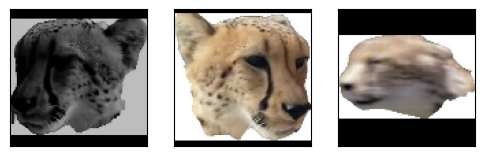

Example semi-hard triplet batch:
1/1 [==============================] - 0s 10ms/step


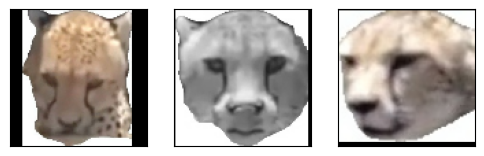

In [15]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(examples[i][0])  # Use the 0 index to remove the batch dimension
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
examples = create_batch(1)
print("Example triplet batch:")
plot_triplets(examples)

print("Example semi-hard triplet batch:")
# 1 example, containing 1 semi-hard
ex_hard = create_hard_batch(1, 1, split="train")
plot_triplets(ex_hard)

In [16]:
# Set up logging directory
## Use date-time as logdir name:
#dt = datetime.now().strftime("%Y%m%dT%H%M")
#logdir = os.path.join("PATH/TO/LOG",dt)

## Use a custom non-dt name:
name = "firstCheetahRecongition"
logdir = os.path.join("trainingLogs",name)

if not os.path.exists(logdir):
    os.mkdir(logdir)

## Callbacks:
# Create the TensorBoard callback
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = logdir,
    histogram_freq=0,
    batch_size=batch_size,
    write_graph=True,
    write_grads=True, 
    write_images = True, 
    update_freq = 'epoch', 
    profile_batch=0
)

# Training logger
csv_log = os.path.join(logdir, 'training.csv')
csv_logger = CSVLogger(csv_log, separator=',', append=True)

# Only save the best model weights based on the val_loss
checkpoint = ModelCheckpoint(os.path.join(logdir, 'snn_model-{epoch:02d}-{val_loss:.2f}.h5'),
                             monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True, 
                             mode='auto')

# Save the embedding mode weights based on the main model's val loss
# This is needed to reecreate the emebedding model should we wish to visualise
# the latent space at the saved epoch
class SaveEmbeddingModelWeights(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.best = np.Inf
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("SaveEmbeddingModelWeights requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.best:
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.verbose == 1:
                print("Saving embedding model weights at %s" % filepath)
            embedding_model.save_weights(filepath, overwrite = True)
            self.best = current
            
            # Delete the last best emb_model and snn_model
            delete_older_model_files(filepath)

# Save the embedding model weights if you save a new snn best model based on the model checkpoint above
emb_weight_saver = SaveEmbeddingModelWeights(os.path.join(logdir, 'emb_model-{epoch:02d}.h5'))


callbacks = [tensorboard, csv_logger, checkpoint, emb_weight_saver]


# Save model configs to JSON
model_json = siamese_net.to_json()
with open(os.path.join(logdir, "siamese_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    
model_json = embedding_model.to_json()
with open(os.path.join(logdir, "embedding_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    

hyperparams = {'batch_size' : batch_size,
              'epochs' : epochs, 
               'steps_per_epoch' : steps_per_epoch, 
               'val_steps' : val_steps, 
               'alpha' : alpha, 
               'num_hard' : num_hard, 
               'optimiser' : optimiser,
               'lr' : lr,
               'emb_size' : emb_size
              }


with open(os.path.join(logdir, "hyperparams.json"), "w") as json_file:
    json.dump(hyperparams, json_file)
    
# Set the model to TB
tensorboard.set_model(siamese_net)

def delete_older_model_files(filepath):
    
    model_dir = filepath.split("emb_model")[0]
    
    # Get model files
    model_files = os.listdir(model_dir)
    # Get only the emb_model files
    emb_model_files = [file for file in model_files if "emb_model" in file]
    # Get the epoch nums of the emb_model_files
    emb_model_files_epoch_nums = [file.split("-")[1].split(".h5")[0] for file in emb_model_files]

    # Find all the snn model files
    snn_model_files = [file for file in model_files if "snn_model" in file]

    # Sort, get highest epoch num
    emb_model_files_epoch_nums.sort()
    highest_epoch_num = emb_model_files_epoch_nums[-1]

    # Filter the emb_model and snn_model file lists to remove the highest epoch number ones
    emb_model_files_without_highest = [file for file in emb_model_files if highest_epoch_num not in file]
    snn_model_files_without_highest = [file for file in snn_model_files if highest_epoch_num not in file]

    # Delete the non-highest model files from the subdir
    if len(emb_model_files_without_highest) != 0:
        print("Deleting previous best model file:", emb_model_files_without_highest)
        for model_file_list in [emb_model_files_without_highest, snn_model_files_without_highest]:
            for file in model_file_list:
                os.remove(os.path.join(model_dir, file))

In [ ]:
## Training:
print("Logging out to Tensorboard at:", logdir)
print("Starting training process!")
print("-------------------------------------")

# Compile the original siamese_net directly
siamese_net.compile(loss=triplet_loss, optimizer=optimiser_obj)

# Add the ClearMemory callback

siamese_history = siamese_net.fit_generator(
    data_generator(batch_size, num_hard),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks, 
    workers=0, 
    validation_data=data_generator(batch_size, num_hard, split="test"), 
    validation_steps=val_steps);

print("-------------------------------------")
print("Training complete.")


Logging out to Tensorboard at: trainingLogs/firstCheetahRecongition
Starting training process!
-------------------------------------
1/1 [==============================] - 0s 10ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step


2023-09-29 20:16:11.746561: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2910076800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-29 20:16:11.746595: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-09-29 20:16:11.753715: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-29 20:16:11.823159: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 0s 10ms/step
